In [1]:
import os
from torch.utils.data import Dataset, DataLoader, ConcatDataset,  WeightedRandomSampler
from skimage import io, transform
from torchvision import transforms, utils
import torch
import numpy as np
import nibabel as nib
from random import randint
from PIL import Image
import torch.optim as optim
import time
import QuickNAT as QN
import torch.nn as nn
from my_Dataset import TrainDataset
import matplotlib.pyplot as plt
from weight_axial import weight

In [2]:
gpu_id = 1
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)

device = torch.device('cuda')
print(device)

cuda


In [3]:
sub_idx = 0
slice_idx = 5
T1a_dir = '/home/xiaoyu/MRIdata_group/T1w/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
parc1a_dir = '/home/xiaoyu/MRIdata_group/parc_1/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
total_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)

In [4]:
# T1a_dir ='/home/xiaoyu/test/t1'
# parc1a_dir ='/home/xiaoyu/test/p1'
# total_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)

In [5]:
for sub_idx in range(1,5):
    T1a_dir = '/home/xiaoyu/MRIdata_group/T1w/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
    parc1a_dir = '/home/xiaoyu/MRIdata_group/parc_1/axial/sub{}/slice{}'.format(sub_idx,slice_idx)
    train_data = TrainDataset(T1a_dir=T1a_dir, parc1a_dir = parc1a_dir)
    total_data = total_data + train_data
print(len(total_data))

50


In [6]:
dataloader = DataLoader(total_data, batch_size = 1, shuffle = True, num_workers = 4)
print(len(dataloader))

50


In [7]:
start=time.time()
model = QN.QuickNAT(1,128,178)
nb_param=0
for param in model.parameters():
    nb_param+=np.prod(list(param.data.size()))
print(nb_param)

13177026


In [8]:
model = model.to(device)
weight = weight.to(device)
criterion = nn.NLLLoss(weight = weight)
optimizer = optim.Adam(model.parameters() ,lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

epoch= 0 	 time= 0.2724502722422282 min 	 loss= 5.072325077056885
epoch= 1 	 time= 0.46219847202301023 min 	 loss= 4.6349067115783695
epoch= 2 	 time= 0.6525760928789774 min 	 loss= 4.230525822639465
epoch= 3 	 time= 0.8452498753865559 min 	 loss= 3.9530018091201784
epoch= 4 	 time= 1.0355251789093018 min 	 loss= 3.7620162630081175
epoch= 5 	 time= 1.2251807808876038 min 	 loss= 3.5894578886032105
epoch= 6 	 time= 1.4179288069407145 min 	 loss= 3.474857358932495
epoch= 7 	 time= 1.633166488011678 min 	 loss= 3.3771142292022707
epoch= 8 	 time= 1.8319522698720296 min 	 loss= 3.281295256614685
epoch= 9 	 time= 2.049903082847595 min 	 loss= 3.174132561683655
epoch= 10 	 time= 2.2411304752031964 min 	 loss= 3.0892850756645203
epoch= 11 	 time= 2.432859110832214 min 	 loss= 3.025891327857971
epoch= 12 	 time= 2.623275136947632 min 	 loss= 2.963362469673157
epoch= 13 	 time= 2.8131474256515503 min 	 loss= 2.9058550024032592
epoch= 14 	 time= 3.003276499112447 min 	 loss= 2.831559672355652
ep

KeyboardInterrupt: 

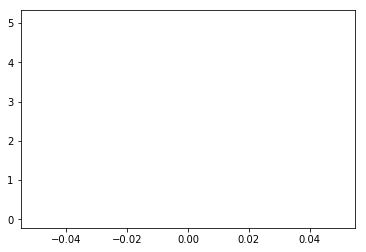

In [9]:
for epoch in range(0,720):
    running_loss = 0
    num_batches = 0
#     scheduler.step()
    for i_batch, sample_batched in enumerate(dataloader):
    
        optimizer.zero_grad()
        
        #get the inputs
        inputs, labels = sample_batched['T1a'], sample_batched['parc1a']
        

        inputs = inputs.to(device)
        labels = labels.to(device)

        inputs.requires_grad_()
        
        #forward + backward +optimize
        scores = model(inputs)

          
        # Define the loss
        loss = criterion(scores, labels.long()) 
        loss.backward()
        optimizer.step()
        
        # compute and accumulate stats
        running_loss += loss.detach().item()

       
        num_batches+=1 
        
        
    # AVERAGE STATS THEN DISPLAY    
    total_loss = running_loss/num_batches
    plt.plot(np.array(total_loss))
   
    elapsed = (time.time()-start)/60
        
    print('epoch=',epoch, '\t time=', elapsed,'min', '\t loss=', total_loss ) 
 
print('Finish Training')

In [11]:
def show_mask(image, mask):
    """
    Show image and mask
    Args:
        image(numpyarray): The training image
        semantic(numpyarray): The training image segmentation
    """    
    plt.subplot(1,2,1)
    plt.title('image')
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('mask')
    plt.imshow(mask)
    plt.show()

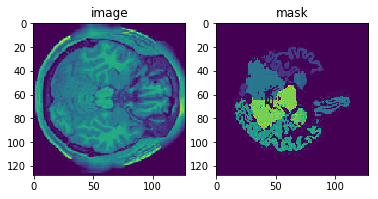

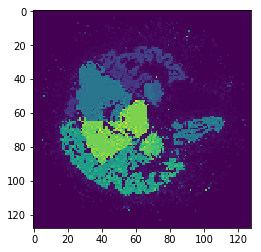

In [12]:
sample=total_data[4]
img = sample['T1a']
mask = sample['parc1a']

show_mask(img.squeeze(), mask)

img = img.unsqueeze(dim = 0)

img = img.to(device)


# feed it to network
scores =  model(img)
scores = scores.detach().cpu().squeeze().permute(1,2,0)

scores = torch.exp(scores)

a,b = torch.max(scores,dim=2)
plt.imshow(b)
